<a href="https://colab.research.google.com/github/McyRoyAl/data_processing/blob/main/data_rep%26proc_p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation

In [ ]:
from PIL import Image
import io, math
import matplotlib.pyplot as plt
import numpy as np

Link to images:
- [bridge.png](https://i.imgur.com/mZJCKsl.png)
- [starry_night.png](https://i.imgur.com/Fovvudy.png)

*(Download these and upload them to colab using the following code block.)*

In [ ]:
# Upload new image files manually (use the download links at the top of the page)
from google.colab import files
uploaded = files.upload()

Mounting the image from drive (not needed):

In [ ]:
 from google.colab import drive
 drive.mount('/content/gdrive')
 image = Image.open('/content/gdrive/MyDrive/236201/bridge.png')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Utils

In [ ]:
def array_to_image(a, colors=False, size=512):
  """Utility function for printing an array as an image"""
  return Image.fromarray((a if colors else a * 256.0).astype(np.uint8)) \
    .resize((size, size), resample=0)

In [ ]:
def tile_images(images, columns, margin=64, right_margin=0):
  """Generate a tiled grid containing all of the images.
  (Assume all images are the same size.)"""
  arr = list(map(lambda image: np.array(image), images))
  rows = math.ceil(len(arr) / columns)
  columns = len(arr[:columns])  # real columns (less than param if rows is 1)
  height = arr[0].shape[0] * rows + margin * (rows - 1)
  width = arr[0].shape[1] * columns + margin * (columns - 1) + right_margin
  tiled = np.ones((height, width)).astype(np.uint8) * 255
  for idx in range(len(arr)):
    i = int(idx / columns); j = idx % columns
    x = i * (arr[0].shape[0] + margin); y = j * (arr[0].shape[1] + margin)
    tiled[x: x + arr[0].shape[0], y: y + arr[0].shape[1]] = arr[idx]
  return Image.fromarray(tiled)

# 1. Quantization

In [ ]:
image = Image.open("/content/bridge.png")
image, _, _ = image.split()  # we only need one component
assert(len(image.histogram()) == 256)

In [ ]:
factor = sum(image.histogram())
p = list(map(lambda value: value / factor, image.histogram()))

In [ ]:
def uniform_quantization(p, b, n=256):
  """Calculates the decision and representation levels for a uniform quantization
  using b bits."""
  delta = n >> b  # the size of each interval
  d = list(map(lambda i: i * delta, range(1 << b)))
  d.append(n)  # add the final decision level
  r = list(map(lambda i: (2 * i * delta + delta - 1) / 2, range(1 << b)))
  return d, r

assert(uniform_quantization(p, 1) == ([0, 128, 256], [63.5, 191.5]))

In [ ]:
def quantization_error(p, d, r):
  """Calculates the quantization error given the pixel distribution, decision and
  representation levels."""
  error = 0
  for i in range(len(r)):
    for x in range(math.ceil(d[i]), math.ceil(d[i + 1])):
      error += math.pow(x - r[i], 2) * p[x]
  return error

In [ ]:
def max_lloyd_update(p, d, r):
  """Helper function for Max-Lloyd quantization."""
  r_prime = r  # update r
  for i in range(len(r)):
    num = 0; denom = 0
    for x in range(math.ceil(d[i]), math.ceil(d[i + 1])):
      num += x * p[x]
      denom += p[x]
    if denom > 0:
      r_prime[i] = num / denom
    else:
      r_prime[i] = (d[i] + d[i + 1]) / 2
  d_prime = d  # update d
  for i in range(1, len(d) - 1):
    d_prime[i] = (r[i - 1] + r[i]) / 2
  return d_prime, r_prime

In [ ]:
def max_lloyd_quantization(p, b, n=256, epsilon=0.001):
  """Executes Max-Lloyd quantization algorithm for b bits with a convergence
  threshold of epsilon."""
  d, r = uniform_quantization(p, b, n)  # start with a uniform quantization
  e = quantization_error(p, d, r)
  delta = epsilon
  while abs(delta) >= epsilon:  # loop until difference is less than the threshold
    d, r = max_lloyd_update(p, d, r)  # update decision and representation levels
    delta = e - quantization_error(p, d, r)
    e = e - delta  # recalculate error
  return d, r

In [ ]:
def threshold_image(image, d, r):
  """Thresholds all pixels into their nearest representative value and returns the
  new image."""
  arr = np.array(image)
  for i in range(len(r)):
    arr[(d[i] <= arr) & (arr < d[i + 1])] = r[i]  # All values in the array within the
                                                  # decision level are set to
                                                  # the representative value
  return Image.fromarray(arr)

In [ ]:
def quantize_image(image, quantization_algorithm, bits, num_levels=256):
  """Returns a quantized version of the input image using the provided algorithm."""
  p = list(map(lambda value: value / factor, image.histogram()))  # Create pdf
  d, r = quantization_algorithm(p, bits, num_levels)
  quantized = threshold_image(image, d, r)
  return quantized, quantization_error(p, d, r)

## Example 1: Golden Gate Bridge

In [ ]:
image = Image.open("/content/bridge.png")
image, _, _ = image.split()  # we only need one component
assert(len(image.histogram()) == 256)

Original image:


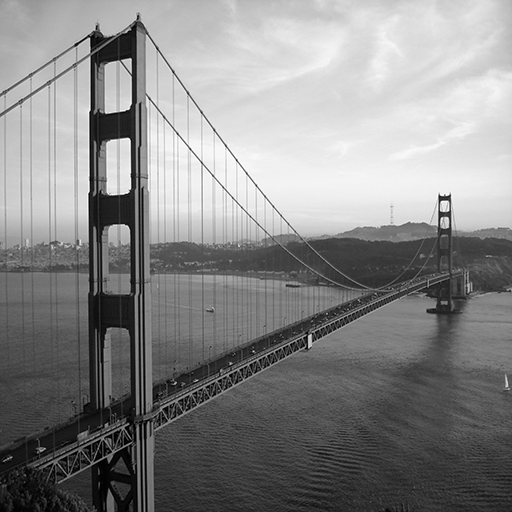

In [ ]:
print("Original image:")
display(image)

Observe the histogram of pixel values in the image. Note that it is very non-uniform with some values being much more common than others.

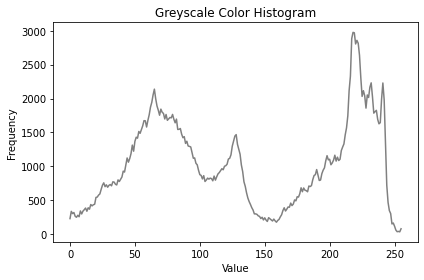

In [ ]:
plt.rcParams["figure.autolayout"] = True

value = list(range(256))
freq = image.histogram()

plt.title("Greyscale Color Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.plot(value, freq, color="grey")

plt.show()

Compare the image and error value between the 3-bit Max-Lloyd quantization and the uniform quantization:


Uniform Quantization with 3 bits:
error: 88.9611587524414


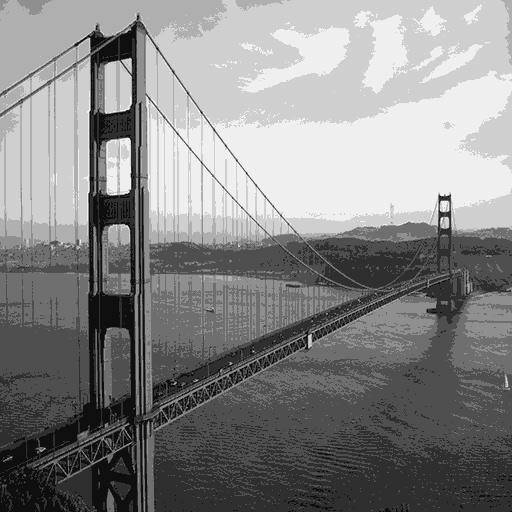

In [ ]:
print(f"Uniform Quantization with 3 bits:")
quantized, error = quantize_image(image, uniform_quantization, 3)
print(f"error: {error}")
display(quantized)

Max-Lloyd Quantization with 3 bits:
error: 66.25696599493928


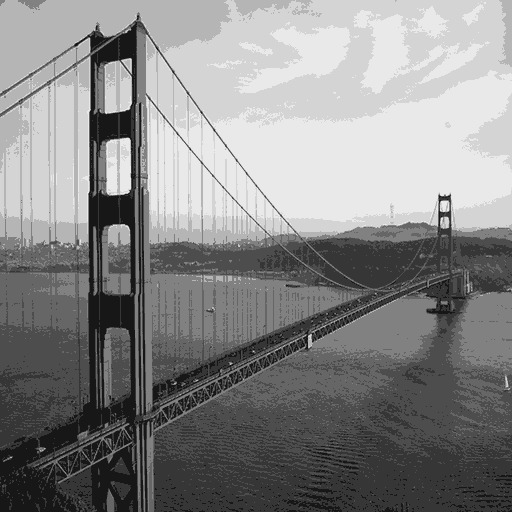

In [ ]:
print(f"Max-Lloyd Quantization with 3 bits:")
quantized, error = quantize_image(image, max_lloyd_quantization, 3)
print(f"error: {error}")
display(quantized)

Show the Max-Lloyd Quantized image for 1 to 8 bits:

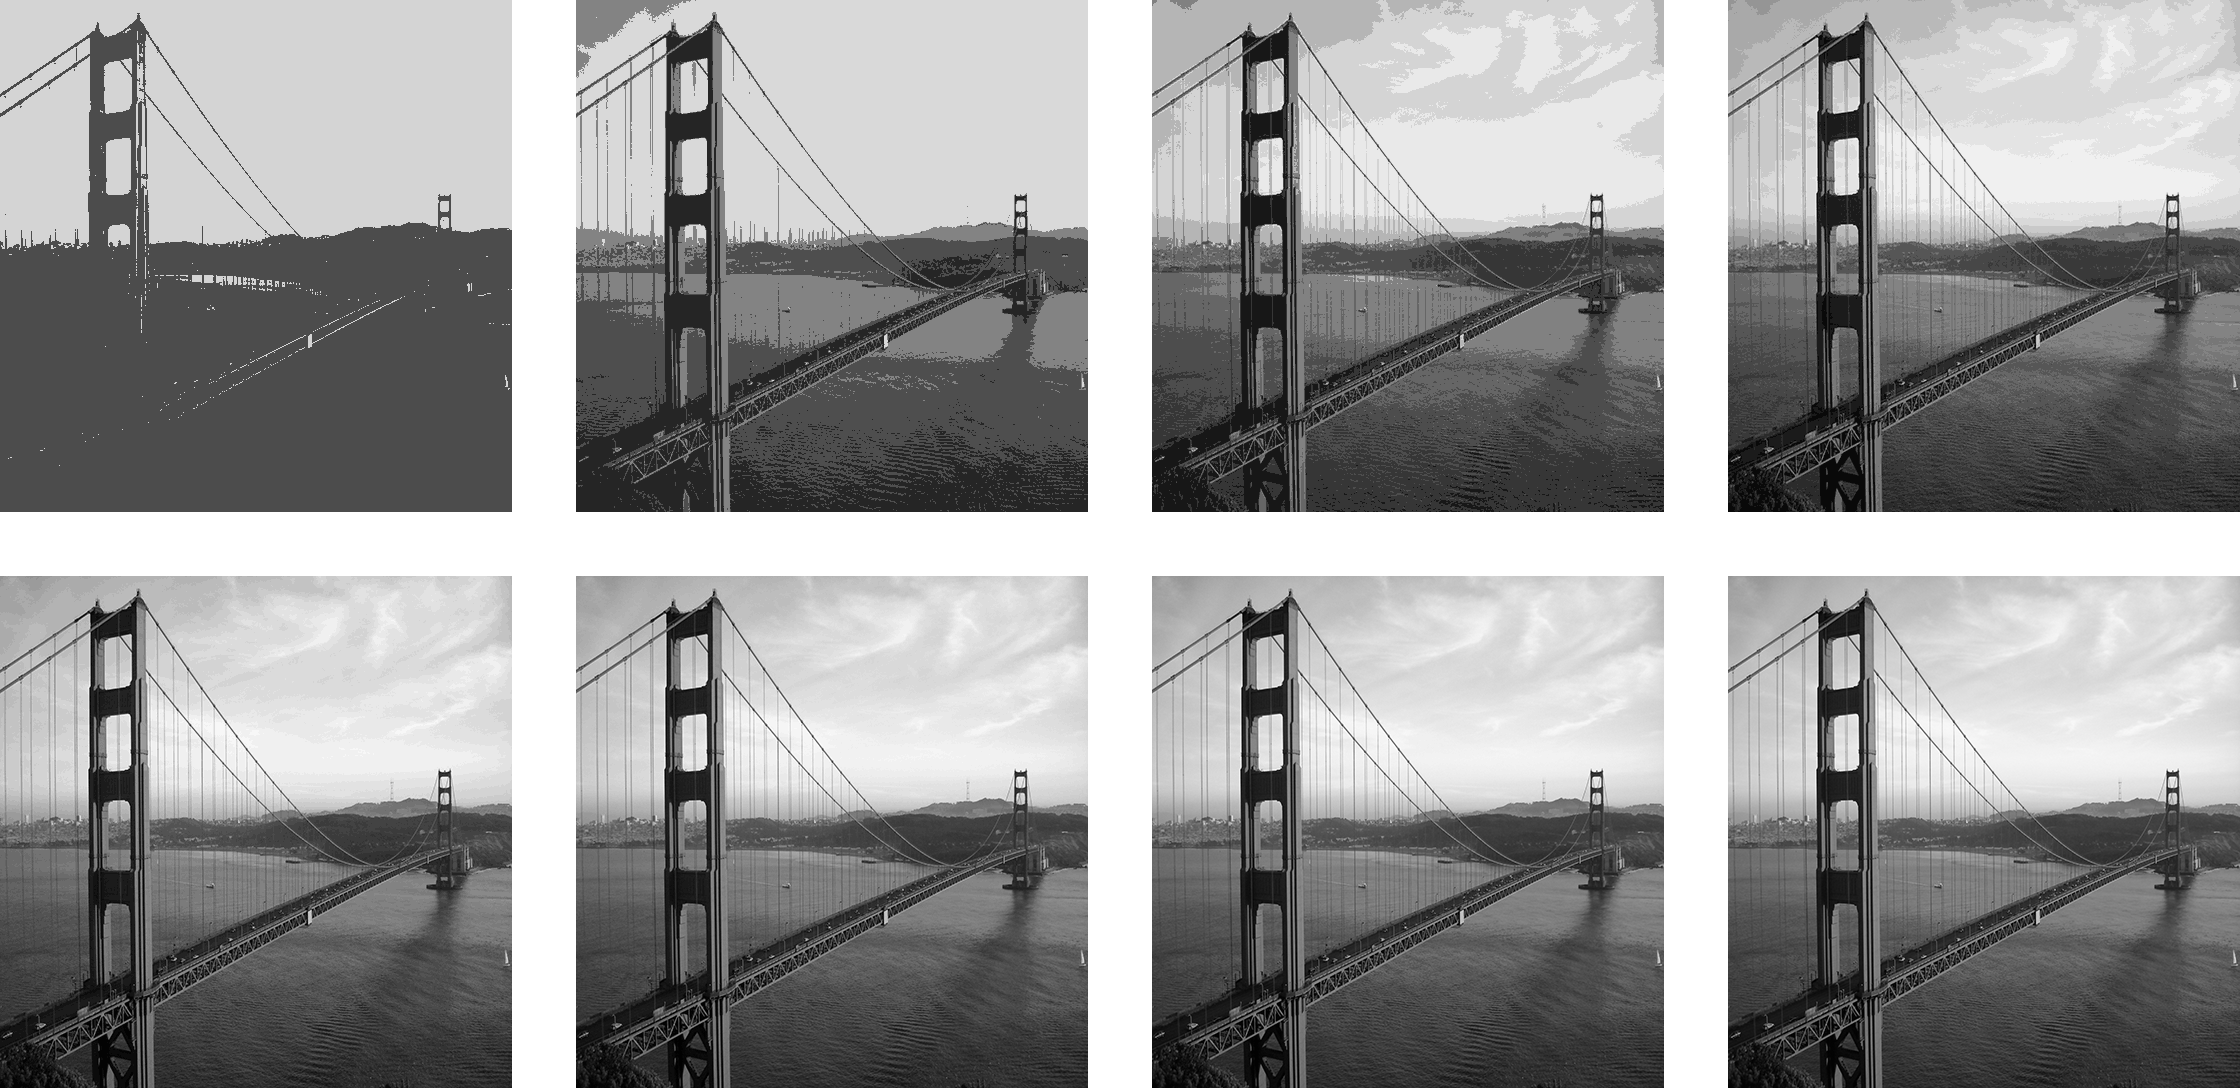

In [ ]:
images = list()
errors = list()
for b in range(1, 9):
  quantized, error = quantize_image(image, max_lloyd_quantization, b)
  images.append(quantized) # display(quantized)
  errors.append(error)

display(tile_images(images, 4))

In [ ]:
print(f"Max-Lloyd Quantization with b bits:\n")
print("  bits  |  error")
print("--------|--------------------")
for b in range(1, 9):
    print(f"  {b}     |  {errors[b - 1]}")
    print("        |")

Max-Lloyd Quantization with b bits:

  bits  |  error
--------|--------------------
  1     |  863.9013046077579
        |
  2     |  265.3354287474474
        |
  3     |  66.25696599493928
        |
  4     |  17.960044248114762
        |
  5     |  4.973215163735866
        |
  6     |  1.2399784723309744
        |
  7     |  0.24941941755945377
        |
  8     |  0.0
        |


## Example 2: Starry Night

As a point of comparison, we show the effect of quantization on a very different image.

In [ ]:
image = Image.open('starry_night.png')
image, _, _ = image.split()  # we only need one component
assert(len(image.histogram()) == 256)

Original image:


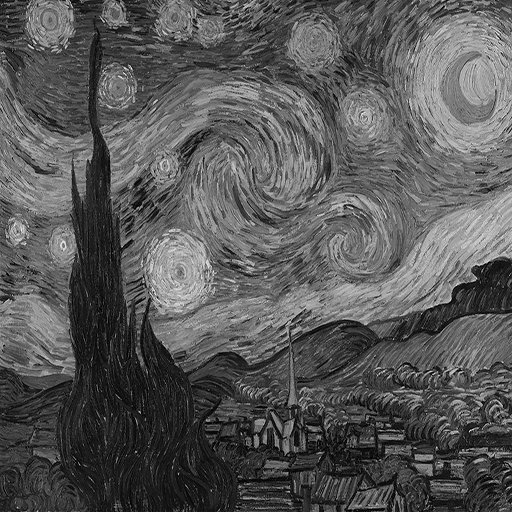

In [ ]:
print(f"Original image:")
display(image)

While the histograms for the two images are both non-uniform, they have a very different profile:

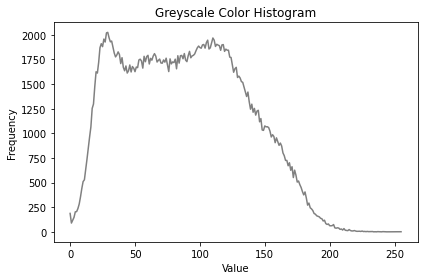

In [ ]:
value = list(range(256))
freq = image.histogram()

plt.title("Greyscale Color Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.plot(value, freq, color="grey")

plt.show()

Compare the image and error value between the 2-bit Max-Lloyd quantization and the uniform quantization:

Uniform Quantization with 2 bits:
error: 314.4675827026367


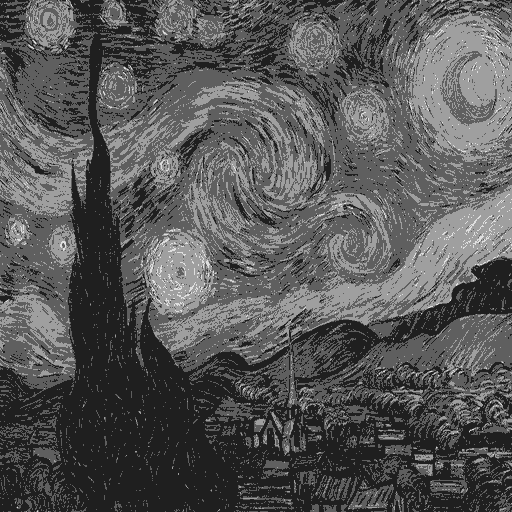

In [ ]:
print(f"Uniform Quantization with 2 bits:")
quantized, error = quantize_image(image, uniform_quantization, 2)
print(f"error: {error}")
display(quantized)

Max-Lloyd Quantization with 2 bits:
error: 163.1158293865772


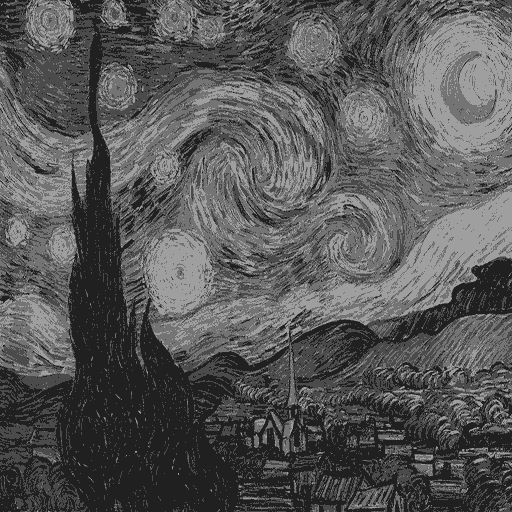

In [ ]:
print(f"Max-Lloyd Quantization with 2 bits:")
quantized, error = quantize_image(image, max_lloyd_quantization, 2)
print(f"error: {error}")
display(quantized)

Show the Max-Lloyd Quantized image for 1 to 8 bits:

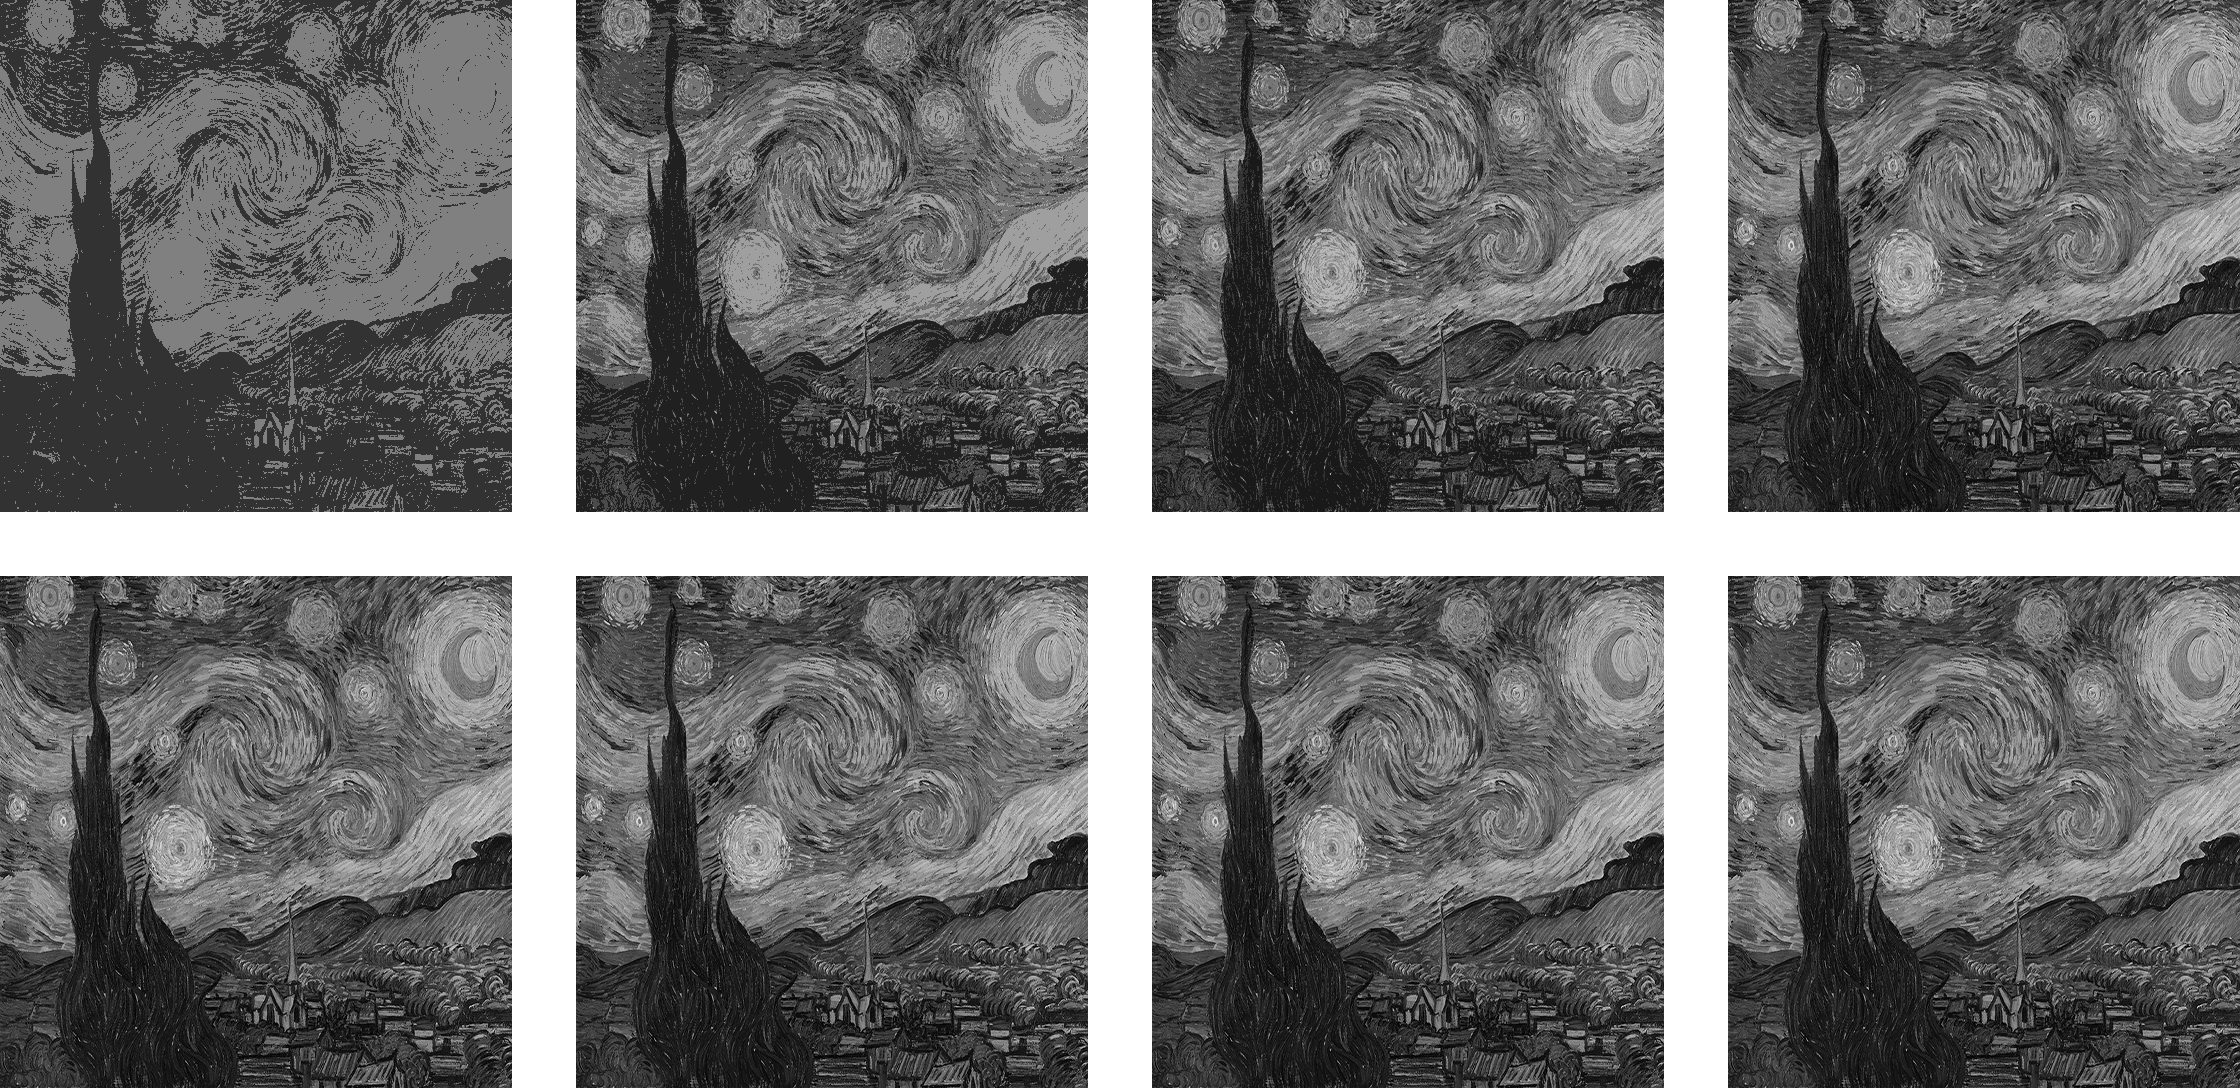

In [ ]:
images = list()
max_lloyd_errors = dict()
for b in range(1, 9):
  quantized, max_lloyd_errors[b] = quantize_image(image, max_lloyd_quantization, b)
  images.append(quantized) # display(quantized)

display(tile_images(images, 4))

In [ ]:
print(f"Max-Lloyd Quantization with b bits:\n")
print("  bits  |  error")
print("--------|--------------------")
for b in range(1, 9):
    print(f"  {b}     |  {max_lloyd_errors[b]}")
    print("        |")

Max-Lloyd Quantization with b bits:

  bits  |  error
--------|--------------------
  1     |  591.5973096016747
        |
  2     |  163.1158293865772
        |
  3     |  48.95551097654127
        |
  4     |  17.157890475995988
        |
  5     |  5.161535131750115
        |
  6     |  1.246765054242212
        |
  7     |  0.2497821001591385
        |
  8     |  0.0
        |


## Results

In [ ]:
# Calculate uniformly quantized image for 1 to 8 bits:
uniform_errors = dict()
for b in range(1, 9):
  quantized, uniform_errors[b] = quantize_image(image, uniform_quantization, b)

Show the MSE as a function of the bit-budget b for b = 1, ..., 8:

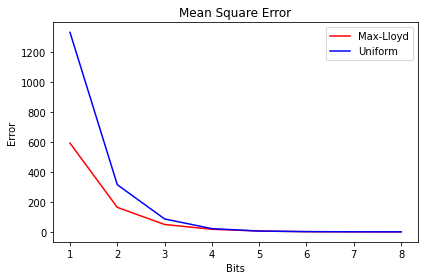

In [ ]:
plt.title("Mean Square Error")
plt.xlabel("Bits")
plt.ylabel("Error")
plt.plot(list(max_lloyd_errors.keys()),
         list(max_lloyd_errors.values()),
         color="red", label='Max-Lloyd')
plt.plot(list(uniform_errors.keys()),
         list(uniform_errors.values()),
         color="blue", label='Uniform')
plt.legend()

plt.show()

Note that the error for Max-Lloyd is consistently lower than that of uniform, but they both rapidly decrease as the bit budget increases.

Plot the decision and representation levels for representative b values.

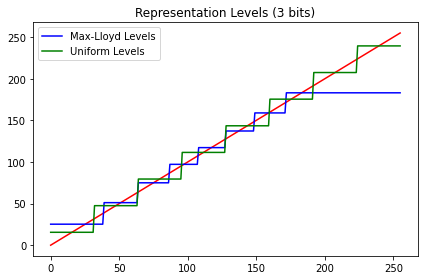

In [ ]:
exact = list(range(256))

def generate_levels(image, quantization_algorithm, b, n=256):
  levels = list(range(n))
  p = list(map(lambda value: value / factor, image.histogram()))  # Create pdf
  d, r = quantization_algorithm(p, b)
  j = 0
  for i in range(n):
    if d[j] <= i:
      j += 1
    levels[i] = r[j - 1]
  return levels

max_lloyd_levels = generate_levels(image, max_lloyd_quantization, 3)
uniform_levels = generate_levels(image, uniform_quantization, 3)

plt.title(f"Representation Levels (3 bits)")
plt.plot(exact, exact, color="red", label='')
plt.plot(exact, max_lloyd_levels, color="blue", label='Max-Lloyd Levels')
plt.plot(exact, uniform_levels, color="green", label='Uniform Levels')
plt.legend()

plt.show()

The quantization levels for the Max-Lloyd algorithm are much wider near the edges and narrower near the center values compared with the uniform quantization. This is because the frequency of central values in the image is higher than the extreme values.

# 2. Subsampling and Reconstruction

In [ ]:
image = Image.open("/content/bridge.png")
image, _, _ = image.split()  # we only need one component
assert(len(image.histogram()) == 256)
frame = np.array(image)

In [ ]:
def divide_intervals(intervals):
  """Split each interval in list into two equal halves."""
  divided = []
  for i in range(len(intervals)):
      mid = int((intervals[i][0] + intervals[i][1]) / 2)
      divided.append((intervals[i][0], mid))
      divided.append((mid + 1, intervals[i][1]))
  return divided

In [ ]:
def generate_intervals(d, rows, cols):
  """Generate list of intervals by dividing array of size (rows x cols)
  in half d times."""
  n = 0
  x_intervals = [(0, cols - 1)]
  y_intervals = [(0, rows - 1)]
  while n != d:
    y_intervals = divide_intervals(y_intervals)
    n += 1
    if n == d:
      break
    x_intervals = divide_intervals(x_intervals)
    n += 1
  intervals = list()
  for y_interval in y_intervals:
    for x_interval in x_intervals:
      intervals.append((y_interval, x_interval))
  return intervals

assert(generate_intervals(d=2, rows=10, cols=12) \
       == [((0, 4), (0, 5)), ((0, 4), (6, 11)), ((5, 9), (0, 5)), ((5, 9), (6, 11))])

In [ ]:
def calculate_MSE(chunk):
  """Returns the MSE over a chunk (2-d slice) of the array."""
  f_hat = np.sum(chunk) / chunk.size  # calculate chunk MSE
  error = np.sum(np.square(chunk - f_hat))
  return f_hat, error

In [ ]:
def calculate_MAD(chunk):
  """Returns the MAD over a chunk (2-d slice) of the array."""
  f_hat = np.median(chunk)  # calculate chunk MAD
  error = np.sum(np.absolute(chunk - f_hat))
  return f_hat, error

In [ ]:
def subsample_image(i, values, calculate):
  """returns the sub-sampled image and the error rate received by
  the sub-sampling factor D = 2^i"""
  intervals = generate_intervals(i, len(values), len(values[0]))
  J = []  # this list stores the subsampled image with the given grid sample regions
  error = 0
  for bounds in intervals:
    chunk = values[bounds[0][0]: bounds[0][1] + 1, bounds[1][0]: bounds[1][1] + 1]
    f_hat, e = calculate(chunk)
    error += e
    J.append(f_hat)
  return J, error

## Subsampling Error

In [ ]:
def showResults(x, y, method):
  """this function generates a plot for sections 2.2.a/b"""
  plt.title(method + " subsampling")
  plt.xlabel("D")
  plt.ylabel("Error")
  plt.grid(alpha = 0.5)
  plt.plot(x, y, color="green")
  plt.show()

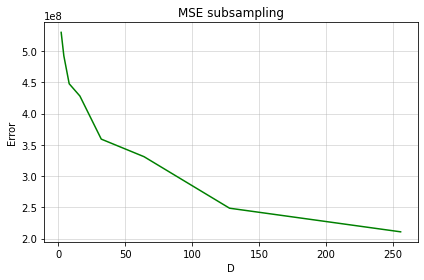

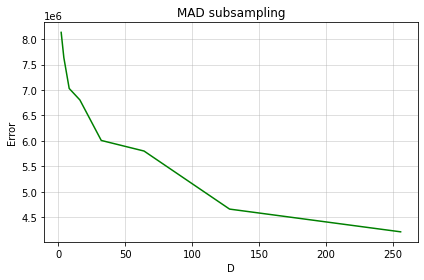

In [ ]:
xAxis = np.empty(8)
yAxis = np.empty(8)

# 2.a section
for i in range(1, 9):
  xAxis[i - 1] = pow(2, i)
  J_tilde, error = subsample_image(i, frame, calculate_MSE)
  yAxis[i - 1] = error
showResults(xAxis, yAxis, "MSE")

# 2.b section
for i in range(1, 9):
  xAxis[i - 1] = pow(2, i)
  J_hat, error = subsample_image(i, frame, calculate_MAD)
  yAxis[i - 1] = error
showResults(xAxis, yAxis, "MAD")

## Reconstructing the Image
Reconstructing the image with the given J_i for any i in range [1,8], then,displaying the received image k_i

In [ ]:
def reconstruct_image(i, values, method):
  """returns the subsampled image using the provided method"""
  rows, cols = values.shape
  intervals = generate_intervals(i, rows, cols)
  J, error = subsample_image(i, values, method)
  subsampled = np.zeros((rows, cols))
  for index, bnds in enumerate(intervals):
    subsampled[bnds[0][0]: bnds[0][1] + 1, bnds[1][0]: bnds[1][1] + 1] = J[index]
  return subsampled

For MSE Subsampling:


K-tilde Reconstruction using 1, 2, 4, 8, ..., 65536 samples:



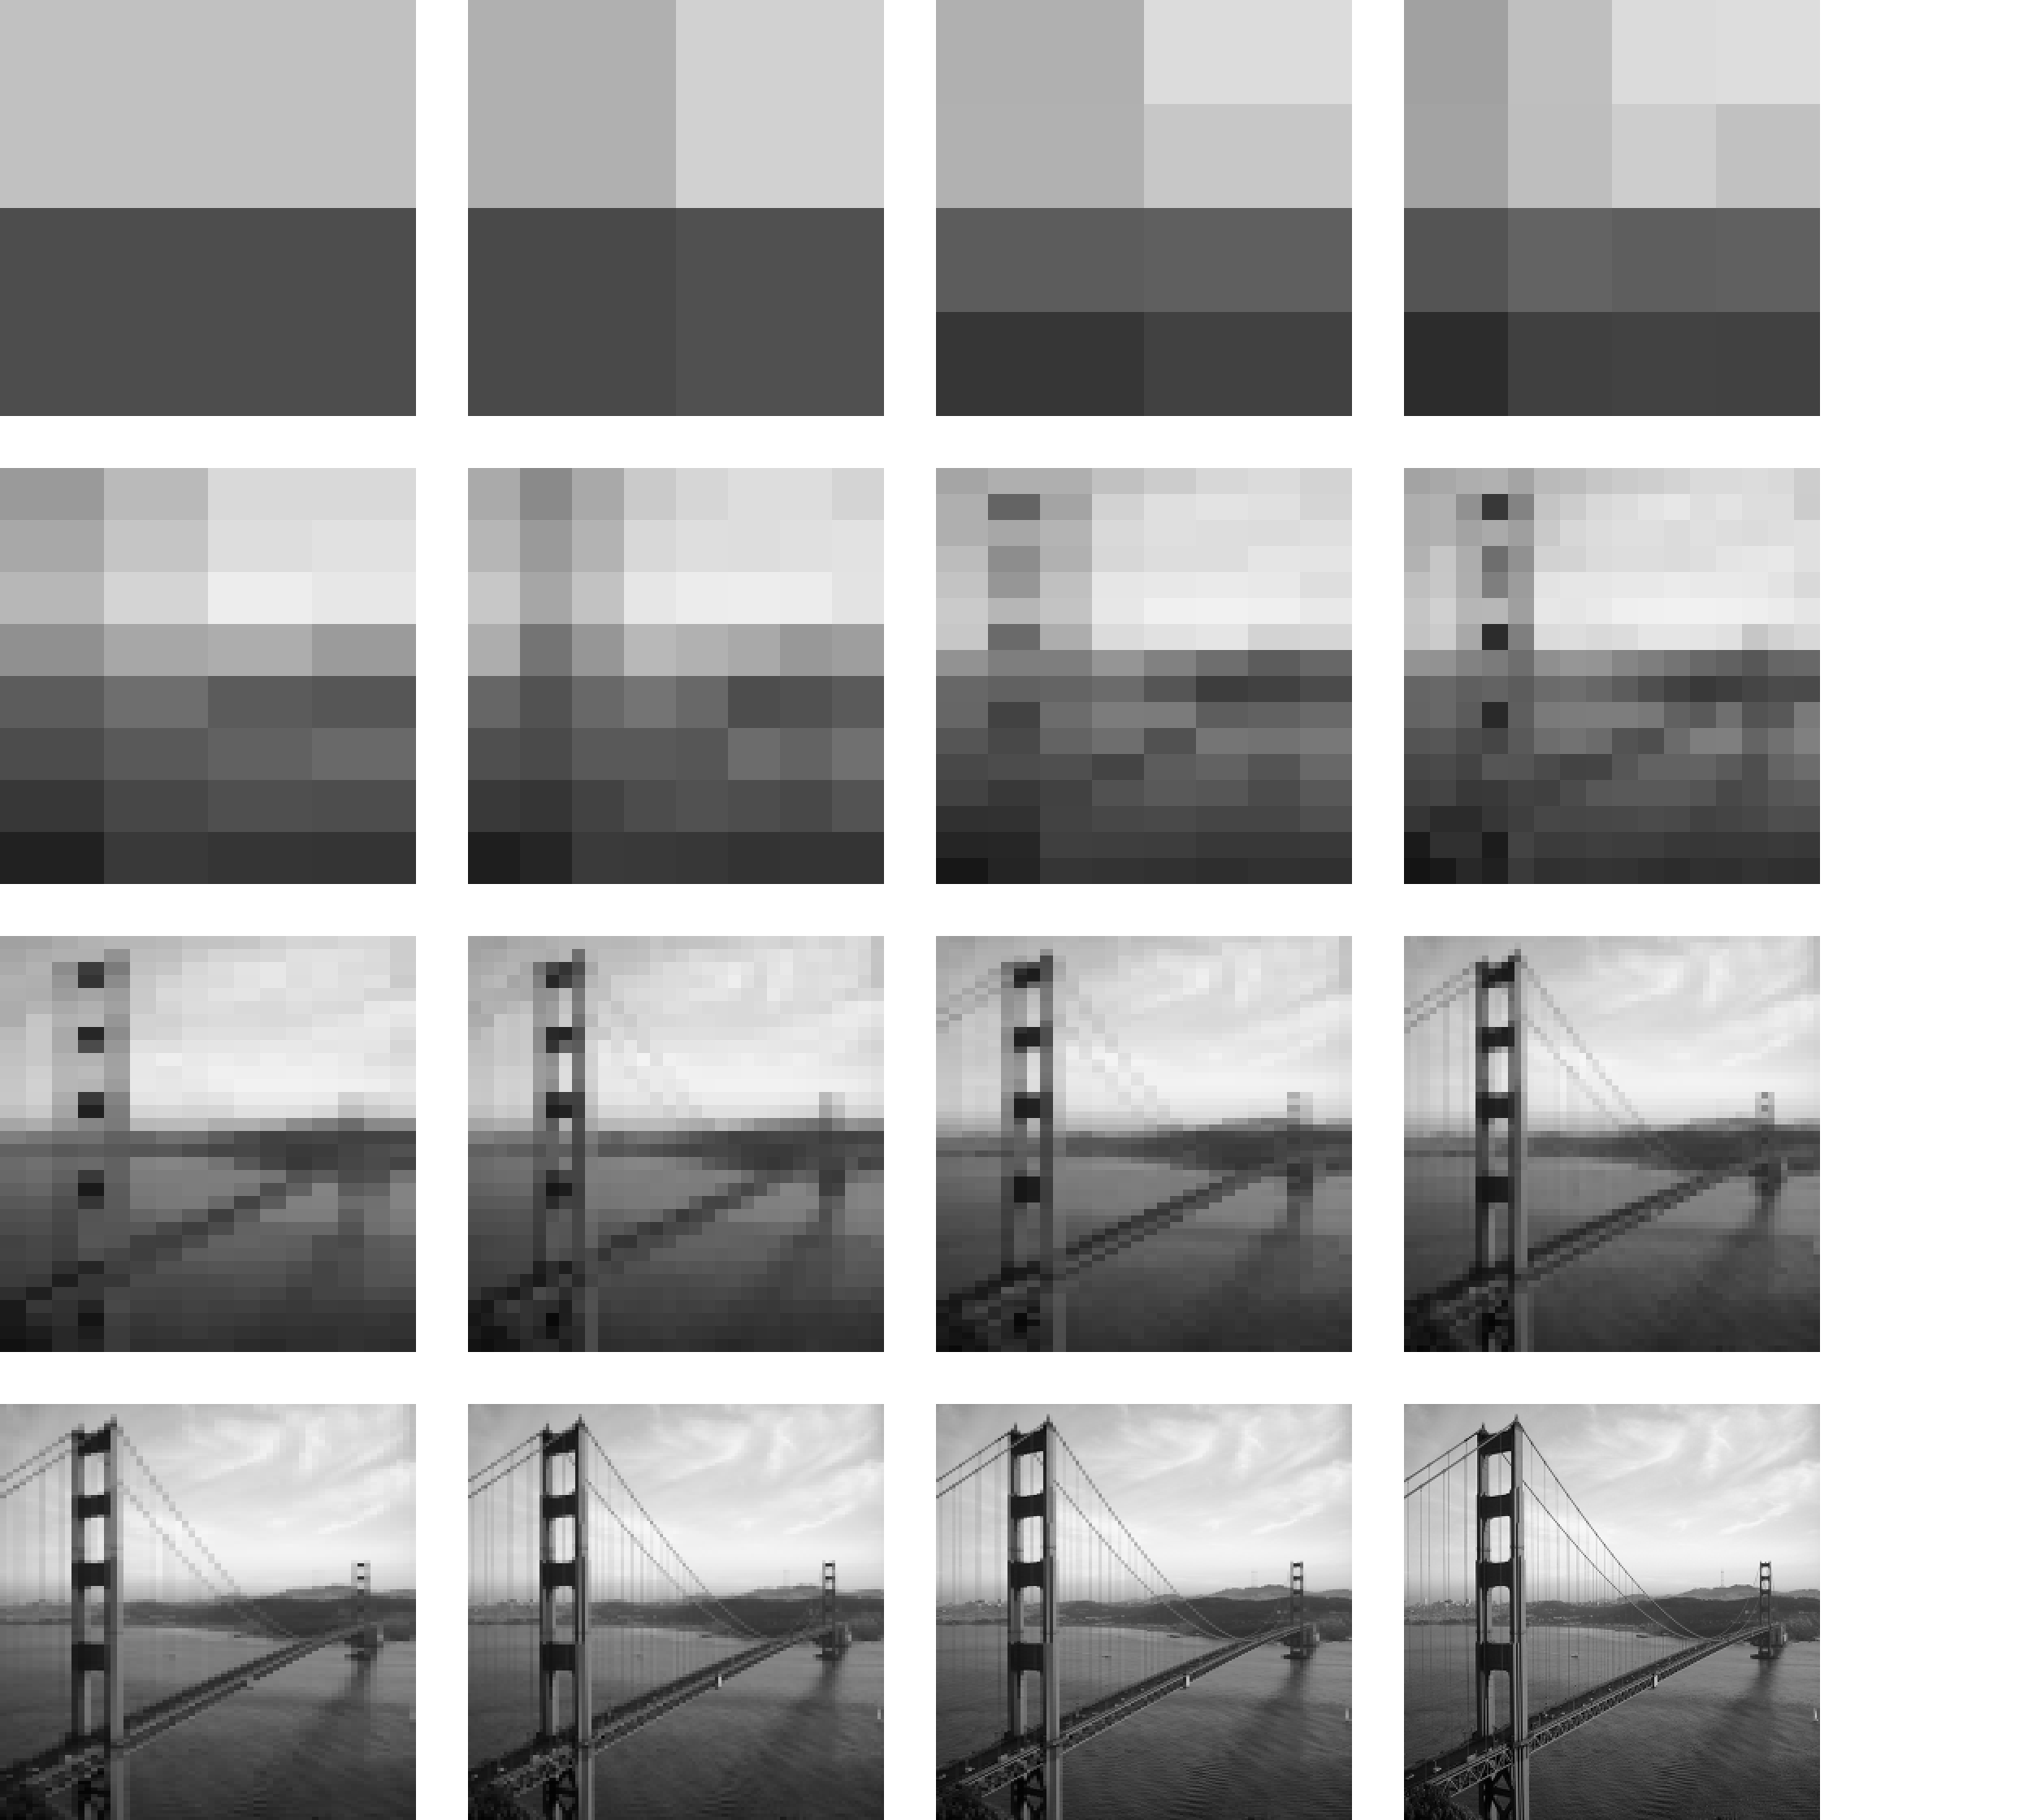

In [ ]:
print(f"\nK-tilde Reconstruction using 1, 2, 4, 8, ..., 65536 samples:\n")

images = list()
for i in range(1, 17):
  values = reconstruct_image(i, frame, calculate_MSE)
  images.append(array_to_image(values, colors=True))

tile_images(images, 4, right_margin=256)

For MAD Subsampling:


K-hat Reconstruction using 1, 2, 4, 8, ..., 65536 samples:



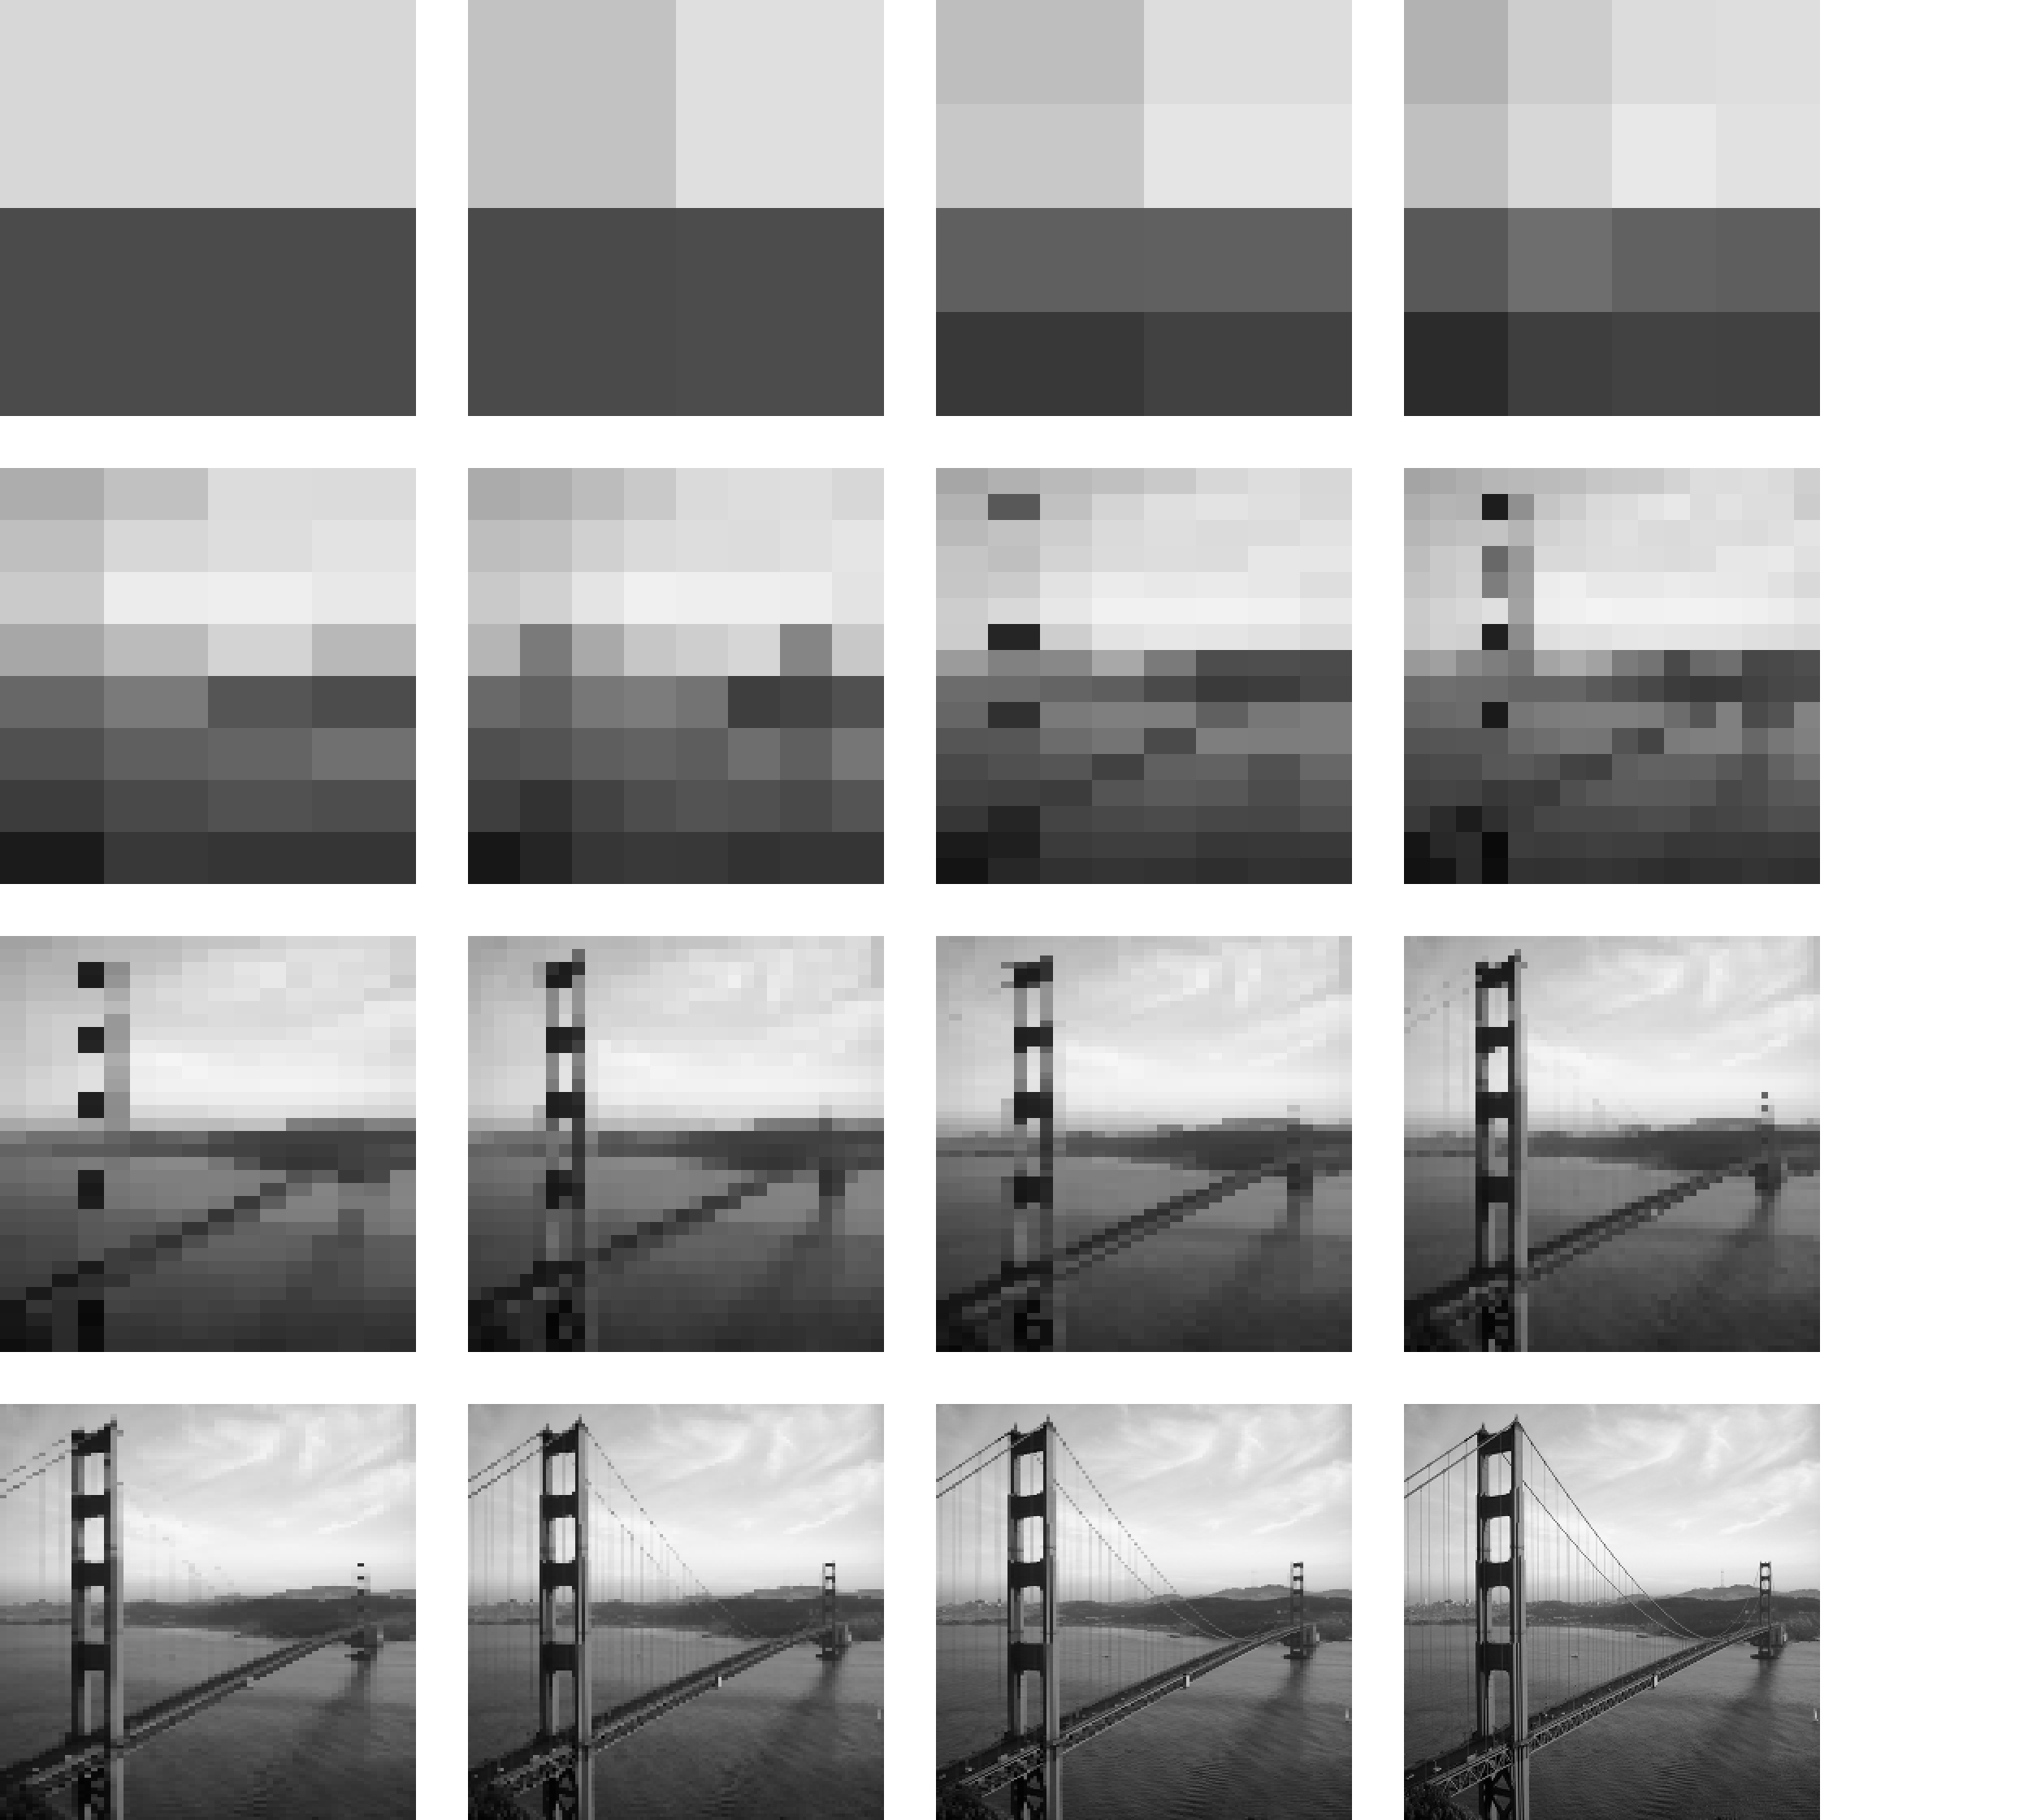

In [ ]:
print(f"\nK-hat Reconstruction using 1, 2, 4, 8, ..., 65536 samples:\n")

images = list()
for i in range(1, 17):
  values = reconstruct_image(i, frame, calculate_MAD)
  images.append(array_to_image(values, colors=True))

tile_images(images, 4, right_margin=256)

## Results

We can see that increasing D reduces the error rate in both methods (MSE and MAD), the reconstructed pictures affirm that the error rates we got are correct because indeed as long as D becomes greater the picture becomes more clear.

# 3. Solving the Lp problem using the L2 solution

In [ ]:
image = Image.open("/content/bridge.png")
image, _, _ = image.split()  # we only need one component
assert(len(image.histogram()) == 256)

## Pseudocode for L-p Solver

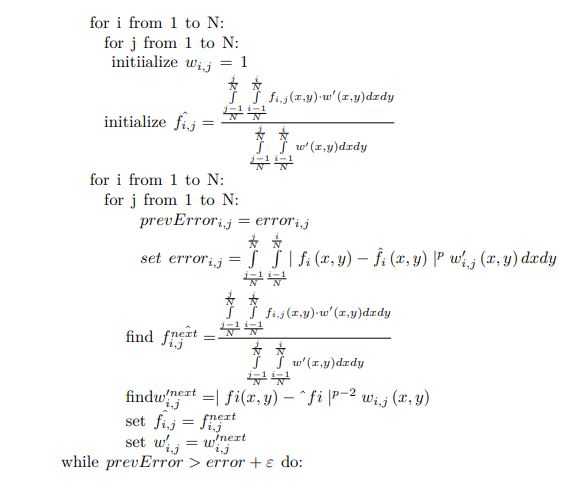

## L-p Solver Implementation

In [ ]:
def chunk_array(a, n, m):
  """Split array a into n x m chunks."""
  return list(map(lambda r: np.array_split(r, m, axis=1),
                  np.array_split(a, n, axis=0)))

In [ ]:
def array_sum(a):
  """Return the array sum of each numpy array in 2-d list a"""
  return list(map(lambda r: list(map(lambda i: np.sum(i), r)), a))

In [ ]:
def L_p_optimizer(f, N, p, epsilon=0.001, max_iter=32):
  w = np.ones(f.shape)  # uniform initial weights
  e = 1 << 32
  delta = epsilon
  while delta >= epsilon and max_iter > 0:  # loop until difference below threshold
    f_hat = np.ones((N, N))
    num = np.reshape(np.array(array_sum(chunk_array(np.multiply(f, w), N, N))), (N, N))
    denom = np.reshape(np.array(array_sum(chunk_array(w, N, N))), (N, N))
    np.putmask(f_hat, denom > 0, num / denom)
     # rescale f_hat to size of f
    f_hat_ = np.array(Image.fromarray(f_hat).resize(f.shape, resample=0))
    w = np.minimum(np.power(np.absolute(f - f_hat_), p - 2), 1 << 32)
    delta = e - np.sum(np.power(np.absolute(f - f_hat_), p))
    e = e - delta  # recalculate error
    max_iter -= 1
  return f_hat

In [ ]:
def L_p_downsample(image, N, p, epsilon=0.001):
  f = np.array(image) / 256.0
  f = L_p_optimizer(f, N, p, epsilon)
  return Image.fromarray((f * 256.0).astype(np.uint8)).resize((512, 512), resample=0)

## L-1 Solver Implementation

In [ ]:
def L_1_optimizer(f, N, epsilon=0.001):
  f_hat = np.zeros((N, N))  # initial f_hat values
  for i in range(N):  # loop through each interval
    for j in range(N):
      chunk = f[int(i * len(f) / N):int((i + 1) * len(f) / N), \
                int(j * len(f[i]) / N):int((j + 1) * len(f[i]) / N)]
      f_hat[i][j] = np.median(chunk)
  return f_hat

In [ ]:
def L_1_downsample(image, N, epsilon=0.001):
  f = np.array(image) / 256.0
  f = L_1_optimizer(f, N, epsilon)
  return Image.fromarray((f * 256.0).astype(np.uint8)).resize((512, 512), resample=0)

## L-2 Solver Implementation

In [ ]:
def L_2_optimizer(f, N, epsilon=0.001):
  f_hat = np.ones((N, N))  # initial f_hat values
  num = np.zeros((N, N))
  denom = np.zeros((N, N))
  for x in range(len(f)):
    for y in range(len(f[0])):
      num[x * N // len(f)][y * N // len(f[0])] += f[x][y]
      denom[x * N // len(f)][y * N // len(f[0])] += 1
  np.putmask(f_hat, denom > 0, num / denom)
  return f_hat

In [ ]:
def L_2_downsample(image, N, epsilon=0.001):
  f = np.array(image) / 256.0
  f = L_2_optimizer(f, N, epsilon)
  return Image.fromarray((f * 256.0).astype(np.uint8)).resize((512, 512), resample=0)

## Results

Compare the results of using the L-1 exact solver with the L-1 approximate solver (using L-p).

*n* = 8, *ϵ* = 0.001

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


L-1 Downsampling (approx):                                       L-1 Downsampling (exact):


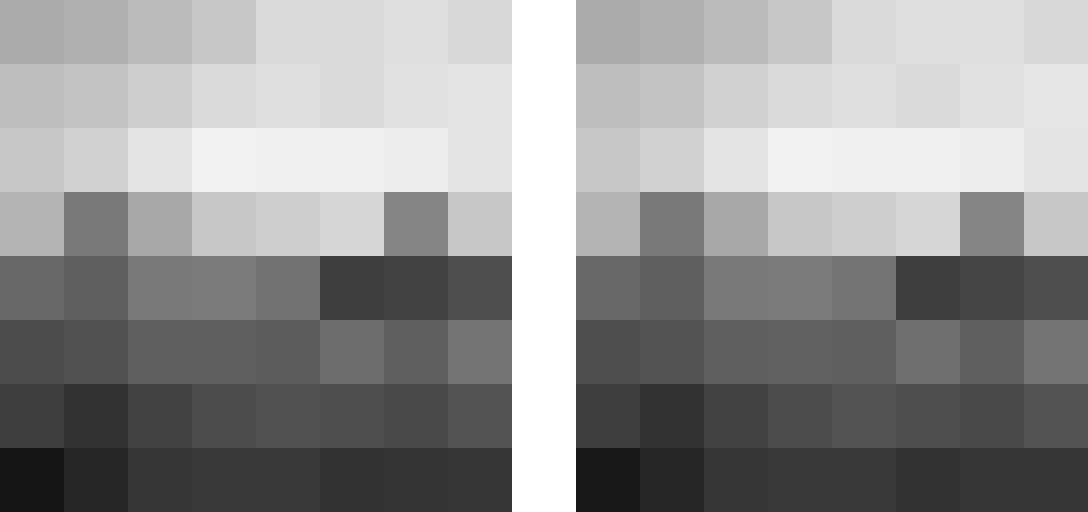

In [ ]:
images = [L_p_downsample(image, 8, 1), L_1_downsample(image, 8)]
print("L-1 Downsampling (approx):                                       " \
      "L-1 Downsampling (exact):")
display(tile_images(images, 2))

n = 64, ϵ = 0.001

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


L-1 Downsampling (approx):                                       L-1 Downsampling (exact):


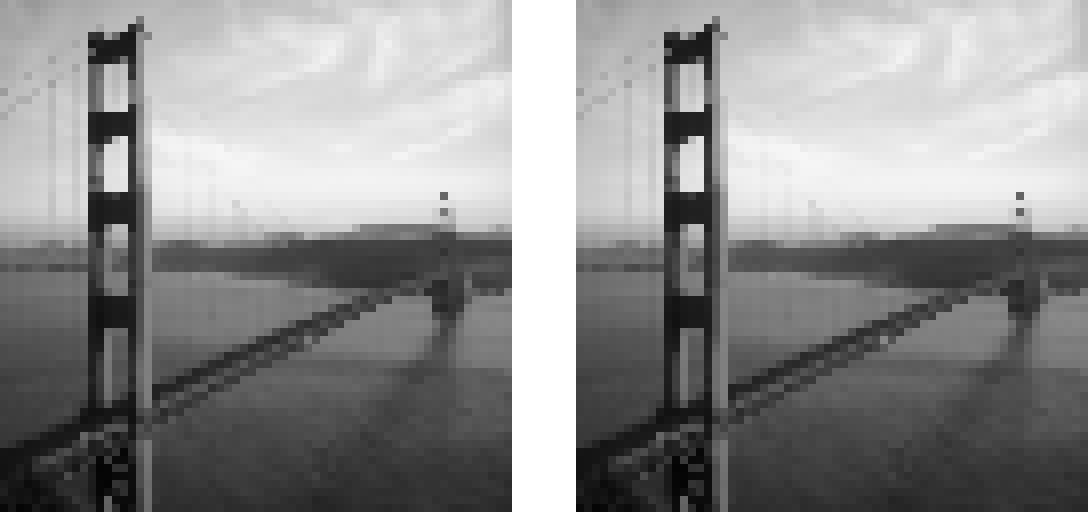

In [ ]:
images = [L_p_downsample(image, 64, 1), L_1_downsample(image, 64)]
print("L-1 Downsampling (approx):                                       " \
      "L-1 Downsampling (exact):")
display(tile_images(images, 2))

n = 8, ϵ = 1000

L-1 Downsampling (approx):                                       L-1 Downsampling (exact):


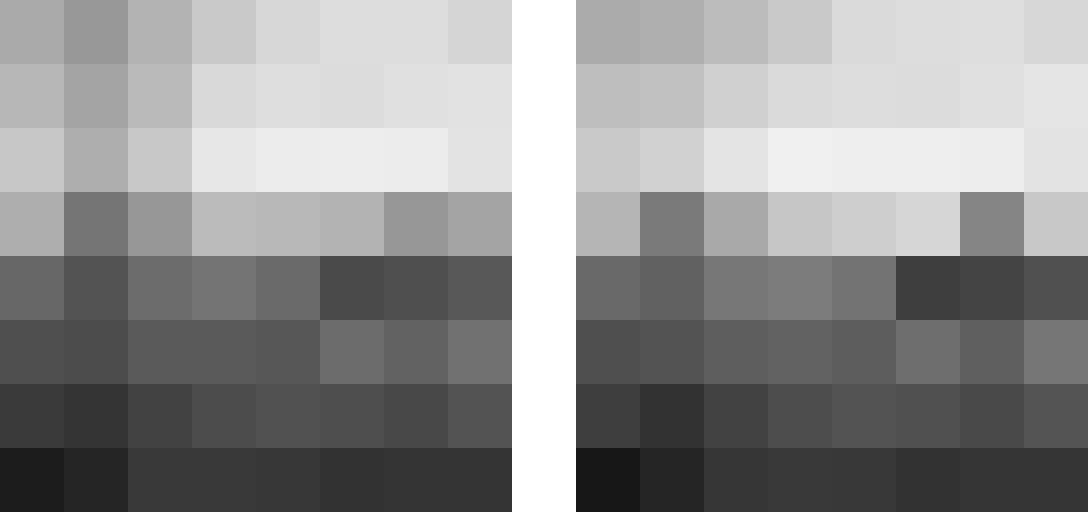

In [ ]:
images = [L_p_downsample(image, 8, 1, epsilon=1000),
          L_1_downsample(image, 8, epsilon=1000)]
print("L-1 Downsampling (approx):                                       " \
      "L-1 Downsampling (exact):")
display(tile_images(images, 2))

n = 64, ϵ = 1000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


L-1 Downsampling (approx):                                       L-1 Downsampling (exact):


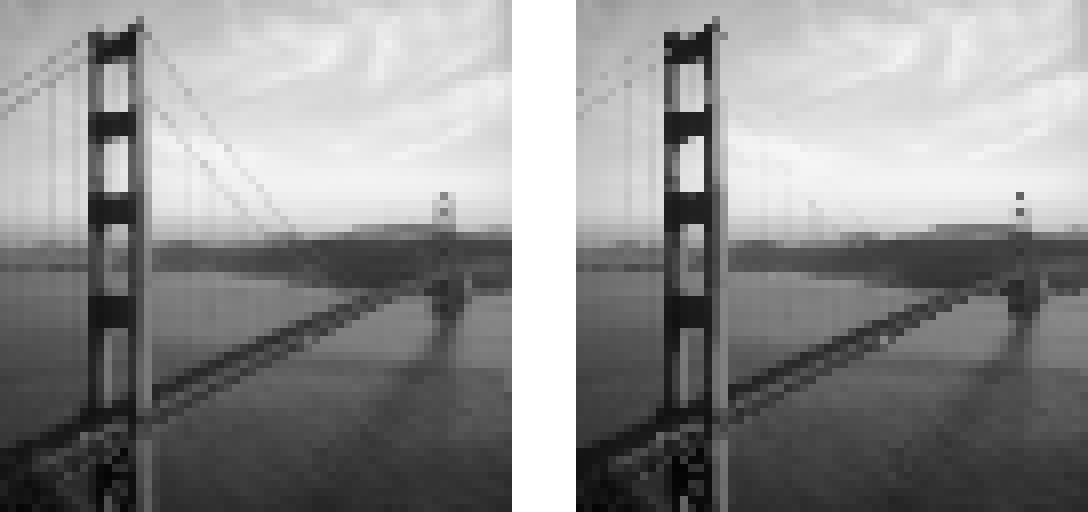

In [ ]:
images = [L_p_downsample(image, 64, 1, epsilon=1000),
          L_1_downsample(image, 64, epsilon=1000)]
print("L-1 Downsampling (approx):                                       " \
      "L-1 Downsampling (exact):")
display(tile_images(images, 2))

When epsilon is made extremely large, slight differences in the pictures can be observed. However, in general this algorithm produces a very close approximation of L-1 and converges quite quickly.

Compute the image downsampled using L-0, L-3/2, L-2, L-4, and L-∞:

n = 8:

L-0 Downsampling:        L-3/2 Downsampling:      L-2 Downsampling:        L-4 Downsampling:        L-∞ Downsampling:


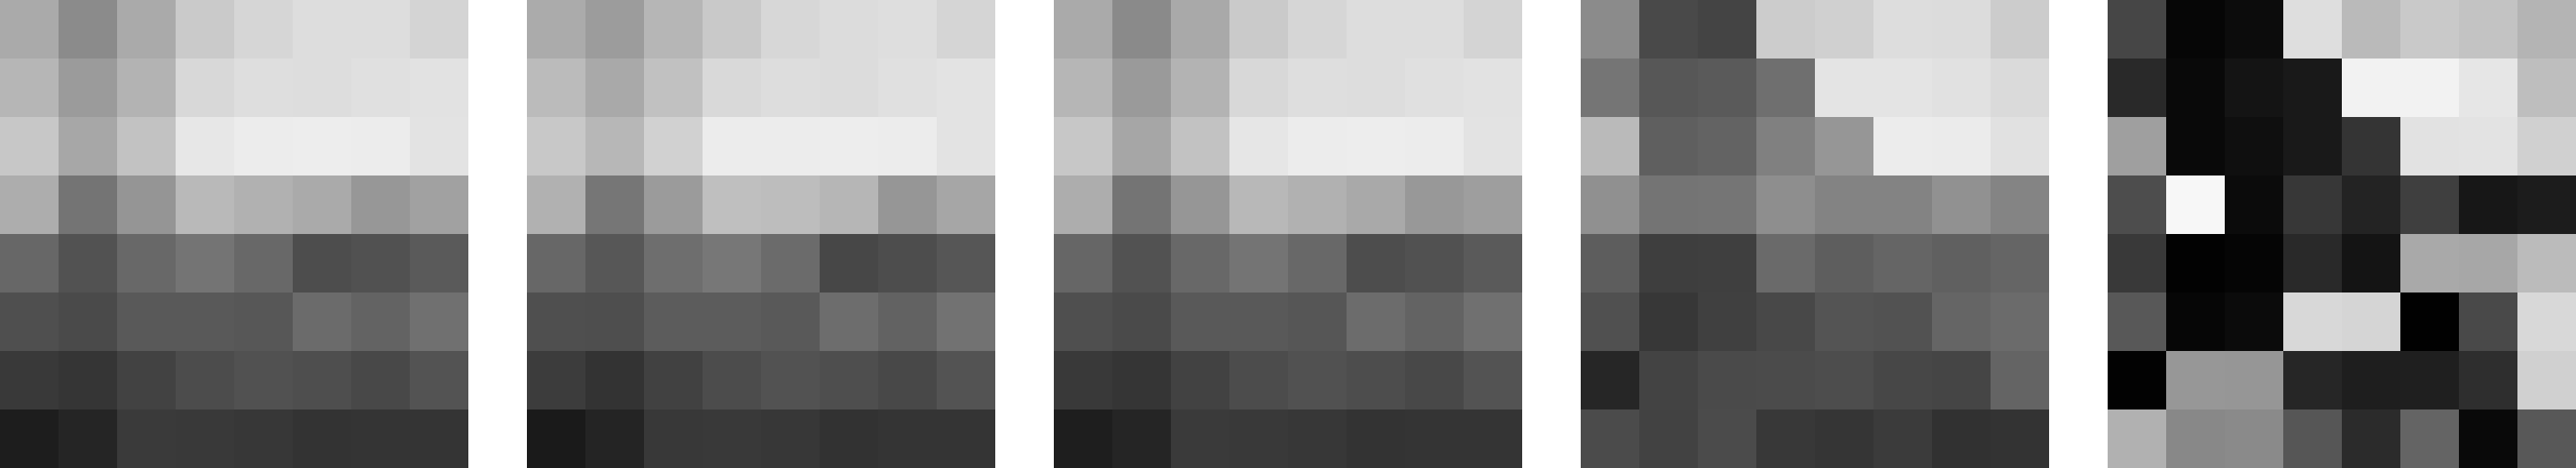

In [ ]:
images = list(map(lambda p: L_p_downsample(image, 8, p), [0, 1.5, 2, 4, 32]))
print("L-0 Downsampling:        L-3/2 Downsampling:      " \
      "L-2 Downsampling:        L-4 Downsampling:        L-∞ Downsampling:")
display(tile_images(images, 5))

n = 64:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


L-0 Downsampling:        L-3/2 Downsampling:      L-2 Downsampling:        L-4 Downsampling:        L-∞ Downsampling:


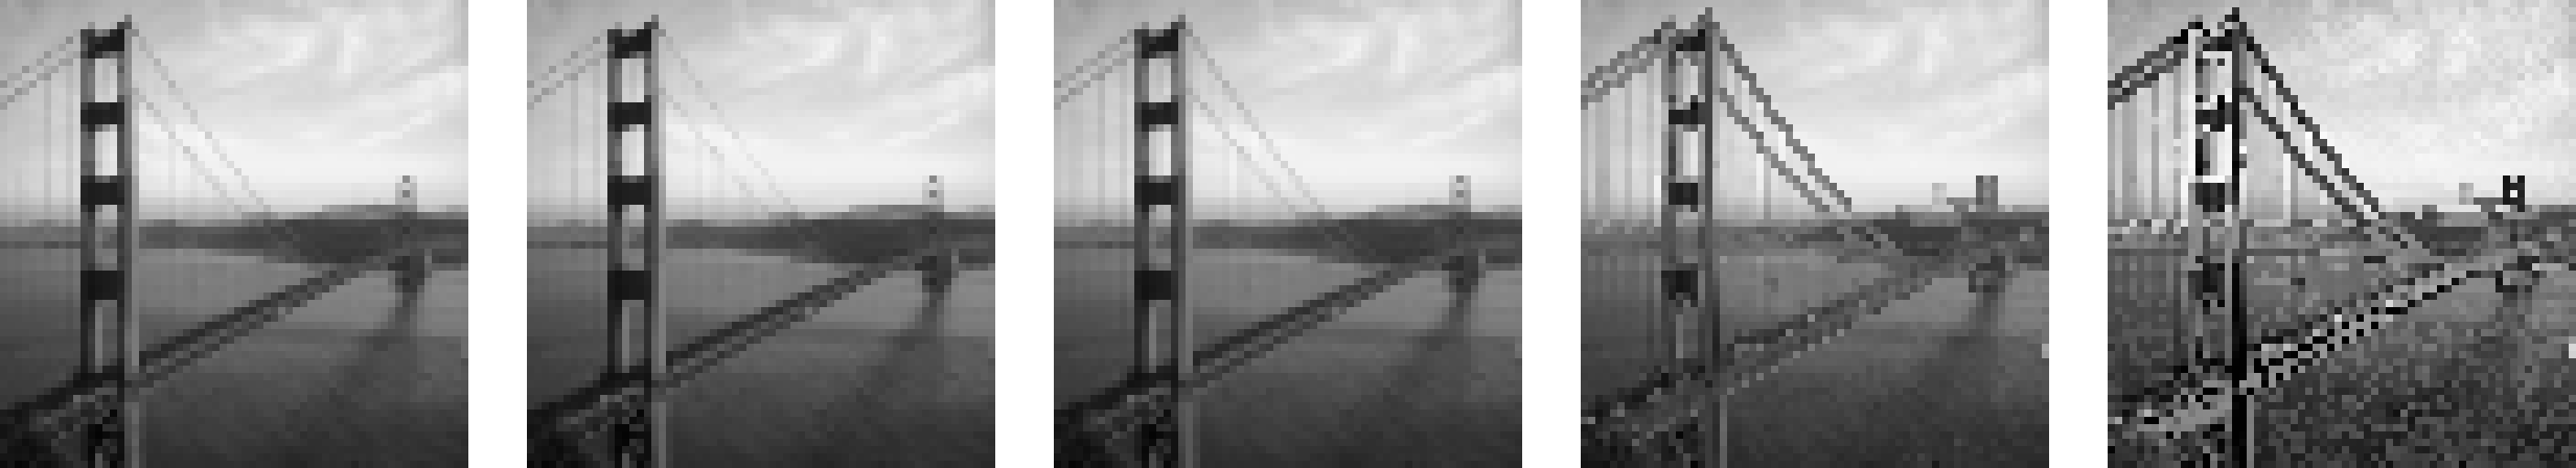

In [ ]:
images = list(map(lambda p: L_p_downsample(image, 64, p), [0, 1.5, 2, 4, 32]))
print("L-0 Downsampling:        L-3/2 Downsampling:      " \
      "L-2 Downsampling:        L-4 Downsampling:        L-∞ Downsampling:")
display(tile_images(images, 5))

The L-2 produces the nicest looking picture for high resolution as expected because it minimizes L-2 error. The L-3/2 sampling is somewhere between L-1 and L-2, and it converges fairly quickly to a near-exact solution. The L-4 and above, however, fail to converge to a solution and the nature of the algorithm gives a result with a large difference from the optimal result. This can be clearly seen in the L-∞ case.